In [18]:
# !pip install python-docx
# 0.8.11

In [78]:
# !pip install PyPDF2
# 2-2.12.1

In [79]:
# brew update
# brew install --cask libreoffice

In [131]:
# !pip install striprtf
# 0.0.22

In [200]:
import pandas as pd
import numpy as np
import json
import os
import re
import docx

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold, train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
import pickle

from pymystem3 import Mystem
import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import RussianStemmer

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [174]:
def getText(filename):
    doc = docx.Document(filename)
    fullText = []
    for para in doc.paragraphs:
        fullText.append(para.text)
    return '\n'.join(fullText)

In [261]:
# Проведем очистку данных: стемминг, единый регистр, удалим знаки препинания, цифры и т.п.

def preprocess(line):
    """
    Функция предобработки текста:
    - очищает текст от цифр и лишних знаков препинания,
    - удаляет короткие слова (состоящие из 1 буквы),
    - удаяет стоп-слова,
    - проводит лемматизацию
    """
    char_regex = re.compile(r'[^а-яa-z]')
    line = char_regex.sub(' ', line.lower())
    
    short_words = re.compile(r'\b[а-яa-z]{1}\b')
    line = short_words.sub(' ', line.lower())
    
    tokenized = toktok.tokenize(line)
    stemmed_str = []
    for i in tokenized:
        if i not in russian_stopwords:
            lemma = m.lemmatize(i)[0]
            stemmed_str.append(str(lemma))
#         stemmed = stemmer.stem(i)
#         stemmed_str += str(stemmed + ' ')
    return ' '.join(stemmed_str)

In [117]:
DOC_PATH = '/Users/mayabikmetova/xmas/hacka-aka-embedika/docs'

In [69]:
a = getText('hacka-aka-embedika/docs/03a70fe60be9ecc2a63798a361fc9689.docx')

In [263]:
m = Mystem()

In [23]:
russian_stopwords = nltk.corpus.stopwords.words('russian')

In [66]:
russian_stopwords.append('страница')

In [14]:
toktok = ToktokTokenizer()
stemmer = RussianStemmer()

In [60]:
from PyPDF2 import PdfReader

reader = PdfReader("hacka-aka-embedika/docs/f57fe87f15a6dee2b17e804421be63b5.pdf")
# количество страниц
num_pages = reader.getNumPages()
text_pages = []

for i in range(num_pages):
    page = reader.pages[i].extract_text()
    text_pages.append(page)

In [63]:
pdf_text = ''.join(text_pages)

In [87]:
!pwd

/Users/mayabikmetova/xmas


In [81]:
doc = 'hacka-aka-embedika/docs/f8eabec67b770c384d84f9feb7e02543.doc'

In [86]:
import subprocess

In [119]:
DOC_PATH

'/Users/mayabikmetova/xmas/hacka-aka-embedika/docs'

In [121]:
# конвертация doc в docx для дальнейшего прочтения

for FILE in os.listdir(DOC_PATH):
    if FILE.split('.')[1] == 'doc':
        subprocess.call(["cd {} && /Applications/LibreOffice.app/Contents/MacOS/soffice \
                         --headless --convert-to docx {} && rm {}".format(DOC_PATH, FILE, FILE)],
                         shell=True)
        print('Конвертирован файл ', FILE)


convert /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/02682d726b725f95b9ee85f751c043d0.doc -> /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/02682d726b725f95b9ee85f751c043d0.docx using filter : Office Open XML Text
Конвертирован файл  02682d726b725f95b9ee85f751c043d0.doc
convert /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/2c81df29db63aebf495106881a52188f.doc -> /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/2c81df29db63aebf495106881a52188f.docx using filter : Office Open XML Text
Конвертирован файл  2c81df29db63aebf495106881a52188f.doc
convert /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/31d24c0d4694e7c2fb19933b84414b40.doc -> /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/31d24c0d4694e7c2fb19933b84414b40.docx using filter : Office Open XML Text
Конвертирован файл  31d24c0d4694e7c2fb19933b84414b40.doc
convert /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/57962abd8dbe0ce0c7056896ee4501f1.doc -> /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/57962abd8dbe0ce

Конвертирован файл  49bce5af1c98cd017a310ea8edd3e55b.doc
convert /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/a0e06a957c1a729fe1d978605680e2ae.doc -> /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/a0e06a957c1a729fe1d978605680e2ae.docx using filter : Office Open XML Text
Конвертирован файл  a0e06a957c1a729fe1d978605680e2ae.doc
convert /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/073a0d372820c3c2bffe9ba24a7ed7af.doc -> /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/073a0d372820c3c2bffe9ba24a7ed7af.docx using filter : Office Open XML Text
Конвертирован файл  073a0d372820c3c2bffe9ba24a7ed7af.doc
convert /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/7ecd641f2ad81961c17455ed3ebeb2ab.doc -> /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/7ecd641f2ad81961c17455ed3ebeb2ab.docx using filter : Office Open XML Text
Конвертирован файл  7ecd641f2ad81961c17455ed3ebeb2ab.doc
convert /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/2060962a8b7ca4c45dc041c3f624225a.doc -> /Users/m

Конвертирован файл  41b36e9a90f36be9ed2a2b4f44e5c848.doc
convert /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/5908cb5da047d6c9e6dfea6337fb3189.doc -> /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/5908cb5da047d6c9e6dfea6337fb3189.docx using filter : Office Open XML Text
Конвертирован файл  5908cb5da047d6c9e6dfea6337fb3189.doc
convert /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/d143c89d002fcef3e2bd2efdb4966f55.doc -> /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/d143c89d002fcef3e2bd2efdb4966f55.docx using filter : Office Open XML Text
Конвертирован файл  d143c89d002fcef3e2bd2efdb4966f55.doc
convert /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/bdfb262c00991dddebfc5d4a87604284.doc -> /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/bdfb262c00991dddebfc5d4a87604284.docx using filter : Office Open XML Text
Конвертирован файл  bdfb262c00991dddebfc5d4a87604284.doc
convert /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/8540a7dccb3a9e4d0a1a2611e077ce9d.doc -> /Users/m

In [124]:
for FILE in os.listdir(DOC_PATH):
    if FILE.split('.')[1] != 'doc' and FILE != '.DS_Store':
        print(FILE)

910ccf7c9b029846e4390ddac5f8d687.docx
69ab7557dee21939aa7432b23a54cb2b.docx
bec0aa38d1383172690a18d16b07f154.docx
31d24c0d4694e7c2fb19933b84414b40.docx
dda3ea2dc3a078682620f926a54aa0bf.docx
cbf3217807791a37499a7b8d94616fdc.docx
8ee681886de97951748528c7c78d03a7.docx
2054a58154349bc54b691666fe3f89b1.pdf
f8eabec67b770c384d84f9feb7e02543.docx
e3f3df754bdf7578a71b7a9fa1500ad9.rtf
b40a9d048b199d5f4db62a6a2335f2a0.pdf
3588ff6fb8f5c5a5f70196500198ca3a.docx
bdfb262c00991dddebfc5d4a87604284.docx
f57fe87f15a6dee2b17e804421be63b5.pdf
4db6b233fda895c3bffcb5fdc5b8e1de.rtf
5e9754740f6c89a96cf5996404ec3c27.docx
137eaaa047f557233943012897e46cec.docx
8b82f3c800e486d9da9a13c98f7a40d6.docx
7a120d4c7cec157324effa671e2d0812.docx
7aff676ead9fe323b2c542e60accb1ae.docx
2c81df29db63aebf495106881a52188f.docx
0f7f507d0af90aba3c35484de016d8b4.docx
97d4cf03b88c9e040557ab1b61e2e7a2.docx
242b138fd2025b7a5207876098355e03.docx
855c8450351c98a25ea2ac22a0256c7f.docx
2351cf256df1b683a425211c1ed0e848.docx
259b4813668421411

In [134]:
# opening rtf
import striprtf

from striprtf.striprtf import rtf_to_text

with open('hacka-aka-embedika/docs/e3f3df754bdf7578a71b7a9fa1500ad9.rtf') as infile:
    content = infile.read()
    text = rtf_to_text(content)
print(text)


Приложение № 2
к приказу Минобразования России
от 10.07.2003 № 2994
Примерная форма договора
об оказании платных образовательных услуг негосударственными образовательными организациями
|“||”||||г.|
(место заключения договора)||(дата заключения договора)||
Негосударственная образовательная организация  	
(полное наименование организации)
		(в дальнейшем – Исполнитель) на основании 

лицензии №||, выданной||
|||(наименование органа, выдавшего лицензию)|
|на срок с “||”||||г. до “||”||||г.,   |
и свидетельства о государственной аккредитации №||, выданного|

(наименование органа, выдавшего свидетельство)
на срок с “||”||||г. до “||”||||г. (для организаций,    |
прошедших государственную аккредитацию), в лице  	
(должность, фамилия, имя, отчество)
		, действующего на основании Устава Исполнителя, с одной 

стороны, и  	
(фамилия, имя, отчество и статус законного представителя несовершеннолетнего - мать,
отец, опекун, попечитель, уполномоченный представитель органа опеки и попечительства
или

In [113]:
# разметка
with open('hacka-aka-embedika/classes.json', 'r') as f:
    data = json.load(f)
    
labels = pd.DataFrame({'filename': data.keys(), 'class': data.values()})

In [126]:
labels['extension'] = labels['filename'].apply(lambda x: x.split('.')[1])

In [127]:
labels

,filename,class,extension
0,5908cb5da047d6c9e6dfea6337fb3189.doc,Договоры для акселератора/Договоры поставки,doc
1,14711e4fc8e56f0c75856c8837ec04cb.doc,Договоры для акселератора/Договоры поставки,doc
2,7eb67b5aecf3f3190aab0a5f8ea32172.docx,Договоры для акселератора/Договоры поставки,docx
3,b40a9d048b199d5f4db62a6a2335f2a0.pdf,Договоры для акселератора/Договоры поставки,pdf
4,84fec112d02288861e7af59f468131fb.docx,Договоры для акселератора/Договоры поставки,docx
...,...,...,...
115,f57fe87f15a6dee2b17e804421be63b5.pdf,Договоры для акселератора/Договоры купли-продажи,pdf
116,1ea8809d696a4bd6a2076fbc6fd28c23.doc,Договоры для акселератора/Договоры купли-продажи,doc
117,57962abd8dbe0ce0c7056896ee4501f1.doc,Договоры для акселератора/Договоры купли-продажи,doc
118,2c81df29db63aebf495106881a52188f.doc,Договоры для акселератора/Договоры купли-продажи,doc


In [115]:
labels['class'].unique()

array(['Договоры для акселератора/Договоры поставки',
       'Договоры для акселератора/Договоры оказания услуг',
       'Договоры для акселератора/Договоры подряда',
       'Договоры для акселератора/Договоры аренды',
       'Договоры для акселератора/Договоры купли-продажи'], dtype=object)

In [197]:
labels['class'] = labels['class'].map({'Договоры для акселератора/Договоры поставки':'Поставки',
       'Договоры для акселератора/Договоры оказания услуг':'Услуги',
       'Договоры для акселератора/Договоры подряда': 'Подряд',
       'Договоры для акселератора/Договоры аренды':'Аренда',
       'Договоры для акселератора/Договоры купли-продажи':'Купля-продажа'})

In [128]:
labels['extension'].unique()

array(['doc', 'docx', 'pdf', 'rtf'], dtype=object)

In [129]:
for ext in labels['extension'].unique():
    print('{} файлов: {}'.format(ext, labels[labels['extension']==ext].shape[0]))

doc файлов: 81
docx файлов: 22
pdf файлов: 13
rtf файлов: 4


In [136]:
# меняем doc extensions на docx, т.к. ранее произвели конвертацию
for (i, fn), ext in zip(enumerate(labels['filename']), labels['extension']):
    if ext == 'doc':
        labels.loc[i, 'filename'] += 'x'

In [198]:
labels

,filename,class,extension,abs_path
0,5908cb5da047d6c9e6dfea6337fb3189.docx,Поставки,doc,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...
1,14711e4fc8e56f0c75856c8837ec04cb.docx,Поставки,doc,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...
2,7eb67b5aecf3f3190aab0a5f8ea32172.docx,Поставки,docx,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...
3,b40a9d048b199d5f4db62a6a2335f2a0.pdf,Поставки,pdf,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...
4,84fec112d02288861e7af59f468131fb.docx,Поставки,docx,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...
...,...,...,...,...
115,f57fe87f15a6dee2b17e804421be63b5.pdf,Купля-продажа,pdf,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...
116,1ea8809d696a4bd6a2076fbc6fd28c23.docx,Купля-продажа,doc,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...
117,57962abd8dbe0ce0c7056896ee4501f1.docx,Купля-продажа,doc,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...
118,2c81df29db63aebf495106881a52188f.docx,Купля-продажа,doc,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...


In [139]:
for FILE in labels['filename']:
    if FILE.split('.')[1] == 'doc':
        print(FILE)

In [175]:
def text_from_docx(filename):
    doc = docx.Document(filename)
    fullText = []
    
    for para in doc.paragraphs:
        fullText.append(para.text)
        
    return '\n'.join(fullText)

In [176]:
def text_from_pdf(filename):
    reader = PdfReader(filename)
    
    num_pages = reader.getNumPages()
    text_pages = []

    for i in range(num_pages):
        page = reader.pages[i].extract_text()
        text_pages.append(page)
    
    return ''.join(text_pages)

In [177]:
def text_from_rtf(filename):
    with open(filename) as f:
        content = f.read()
        return rtf_to_text(content)

In [240]:
class FileTypeError(Exception):
    def __init__(self, msg='Неверный тип файла! Допустимые типы: doc, docx, pdf, rtf.'):
        super().__init__(msg)


def extract_text(path):
    """
    Функция для выделения текста из документы. Допустимые типы файлов: doc, docx, pdf, rtf.
    
    Параметры:
        path: Путь к обрабатываемому файлу.
    """
    func_dict = {'docx': text_from_docx, 'pdf': text_from_pdf, 'rtf': text_from_rtf}
    
    try:
        filename = os.path.basename(path)
        extension = filename.split('.')[1]

        print('Обрабатывается файл ', path)

        if extension not in ['doc', 'docx', 'pdf', 'rtf']:
            raise FileTypeError
        else:
            text = func_dict[extension](path)

            return text
    except Exception as e:
        print(e)

In [235]:
# проверяем исключение
extract_text('./hacka-aka-embedika/classes.json')

Обрабатывается файл  ./hacka-aka-embedika/classes.json
Неверный тип файла! Допустимые типы: doc, docx, pdf, rtf.


In [236]:
extract_text('./hacka-aka-embedika/docs/086ad48895d2a73854b6151decc28800.pdf')

Обрабатывается файл  ./hacka-aka-embedika/docs/086ad48895d2a73854b6151decc28800.pdf


'(Типовая форма)  \nДОГОВОР КУПЛИ -ПРОДАЖИ №_____  \n \nг. Москва         «___» ________  20___ г. \nАкционерное общество «Государственная транспортная лизинговая компания»  \n(АО «ГТЛК»)  именуемое в дальнейшем « Продавец », в лице ________, действующей на \nосновании ________, с одной стороны, и ________ , именуемое в дальнейшем \n«Покупатель» , в лице ________, действующего на основании ________, с другой стороны, \nименуемые по отдельности « Сторона », а вместе именуемые « Стороны », заключили \nнастоящи й договор (далее – «Договор ») о нижеследующем:  \n \n1. Предмет  Договора  \n \n1.1. В соответствии с настоящим договором Продавец обязуется передать в \nсобственность Покупателя бывшее в употреблении имущество (далее по тексту Договора – \n«Товар »), указанное в Спецификации (Приложение № 1 к Договору), а Покупатель \nобязуется оплатить и принять Товар на условиях и в сроки, установленные настоящим \nДоговором.  \nПеречень Товара, количество и ассортимент приведены в Приложении №

In [190]:
labels['abs_path'] = labels['filename'].apply(lambda x: DOC_PATH+'/'+x)

CPU times: user 1.31 ms, sys: 782 µs, total: 2.09 ms
Wall time: 1.89 ms


In [199]:
labels

,filename,class,extension,abs_path
0,5908cb5da047d6c9e6dfea6337fb3189.docx,Поставки,doc,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...
1,14711e4fc8e56f0c75856c8837ec04cb.docx,Поставки,doc,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...
2,7eb67b5aecf3f3190aab0a5f8ea32172.docx,Поставки,docx,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...
3,b40a9d048b199d5f4db62a6a2335f2a0.pdf,Поставки,pdf,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...
4,84fec112d02288861e7af59f468131fb.docx,Поставки,docx,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...
...,...,...,...,...
115,f57fe87f15a6dee2b17e804421be63b5.pdf,Купля-продажа,pdf,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...
116,1ea8809d696a4bd6a2076fbc6fd28c23.docx,Купля-продажа,doc,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...
117,57962abd8dbe0ce0c7056896ee4501f1.docx,Купля-продажа,doc,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...
118,2c81df29db63aebf495106881a52188f.docx,Купля-продажа,doc,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...


In [201]:
labels['abs_path'][0]

'/Users/mayabikmetova/xmas/hacka-aka-embedika/docs/5908cb5da047d6c9e6dfea6337fb3189.docx'

In [241]:
%%time

labels['source_text'] = labels['abs_path'].apply(extract_text)

Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/5908cb5da047d6c9e6dfea6337fb3189.docx
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/14711e4fc8e56f0c75856c8837ec04cb.docx
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/7eb67b5aecf3f3190aab0a5f8ea32172.docx
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/b40a9d048b199d5f4db62a6a2335f2a0.pdf
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/84fec112d02288861e7af59f468131fb.docx
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/f6377999f8a5aa9a09b03e428ac93153.docx
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/a525f050cef10dee3a42468daec064ff.docx
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/bec0aa38d1383172690a18d16b07f154.docx
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/214d620d9c54bc83111277dd872d3cb2.pdf
Обрабатывается файл  

incorrect startxref pointer(1)


Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/19e2becdb0f10e1c16a5a2460f3a84a2.pdf
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/0f7f507d0af90aba3c35484de016d8b4.docx
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/69ab7557dee21939aa7432b23a54cb2b.docx
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/8b82f3c800e486d9da9a13c98f7a40d6.docx
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/856860329f573bbaf158e1eafa885ba5.docx
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/35b6a0f57d909507c5aa9a8972b15f35.pdf
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/f28d4a853be12515dae73a5912bc5b41.docx
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/2c758805e2917306e6cbb079e2adcfcf.rtf
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/4db6b233fda895c3bffcb5fdc5b8e1de.rtf
Обрабатывается файл  /U

incorrect startxref pointer(1)


Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/7ce2d613ac62ec5e4ef3d988c1f91582.docx
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/2060962a8b7ca4c45dc041c3f624225a.docx
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/b95bbf14eb26ac912b1339e321cbca34.docx
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/910ccf7c9b029846e4390ddac5f8d687.docx
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/82b672721c50b8897a3cf7c98c0d8e0c.rtf
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/81a64023bdb74032827385d43181ea3a.pdf
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/6cd62be718ceb49408c49e00e7b12a5e.docx
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/f8eabec67b770c384d84f9feb7e02543.docx
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/f96c2a58215aa54aeb6713cbb457fad9.docx
Обрабатывается файл  

Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/1ea8809d696a4bd6a2076fbc6fd28c23.docx
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/57962abd8dbe0ce0c7056896ee4501f1.docx
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/2c81df29db63aebf495106881a52188f.docx
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/0ca2f9faecdbc67d6686a9f5b6636eba.docx
CPU times: user 20.4 s, sys: 707 ms, total: 21.1 s
Wall time: 22.3 s


In [238]:
# битый файл??? посмотреть позже, если будет время.
# XMLSyntaxError: Start tag expected, '<' not found, line 1, column 1 (<string>, line 1)

# extract_text('/Users/mayabikmetova/xmas/hacka-aka-embedika/docs/18d573815c15b4e798bdfbfb52fb2f43.docx')

Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/18d573815c15b4e798bdfbfb52fb2f43.docx
Start tag expected, '<' not found, line 1, column 1 (<string>, line 1)


In [255]:
labels[labels['filename']=='18d573815c15b4e798bdfbfb52fb2f43.docx']['source_text'].values

array([None], dtype=object)

In [258]:
# распознать текст битых доков позже
labels[labels['source_text'].isin([None])]

,filename,class,extension,abs_path,source_text
25,18d573815c15b4e798bdfbfb52fb2f43.docx,Услуги,docx,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...,None
71,b303afea664ed05cdbc73a8c3b31b09d.docx,Подряд,docx,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...,None
82,2d4708c800dc003466fa9a8a64e2e2b7.docx,Аренда,docx,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...,None
84,317dc2690741c169db9dc901ff5a3258.docx,Аренда,docx,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...,None


In [260]:
data = labels[~labels['source_text'].isin([None])]

In [264]:
%%time
data['lemma_text'] = data['source_text'].apply(preprocess)

CPU times: user 4.01 s, sys: 1.48 s, total: 5.49 s
Wall time: 14.6 s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## EDA и бейзлайн

<AxesSubplot:xlabel='class', ylabel='count'>

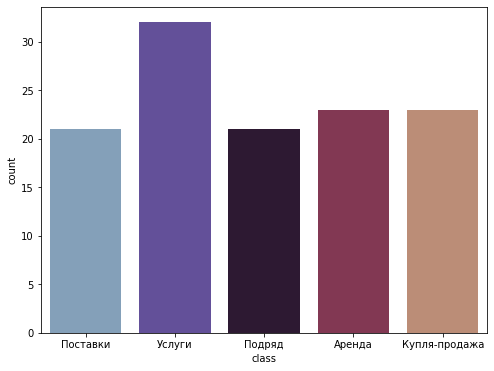

In [269]:
plt.figure(figsize=(8,6))
sns.countplot(x='class', data=labels, palette='twilight')

In [303]:
# d54c0b06162cf7cf57e8b1e7356aa204.docx
# не распознан текст, 2 столбца (1 - рус, 2 - англ)
data[data['lemma_text']=='']

,filename,class,extension,abs_path,source_text,lemma_text
26,d54c0b06162cf7cf57e8b1e7356aa204.docx,Услуги,doc,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...,,


In [306]:
data = data[~data['lemma_text'].isin([''])]

In [307]:
from PIL import Image
from wordcloud import WordCloud

In [308]:
def draw_word_cloud(df, doc_class):
    """Функция для отрисовки облаков слов"""
    text = ''
    for i in df[df['class']==doc_class]['lemma_text'].values:
        text += i+' '

    all_words = nltk.tokenize.word_tokenize(text.lower())
    all_words_no_stop = nltk.FreqDist(w.lower() for w in all_words if w not in russian_stopwords)

    wc = WordCloud(background_color="white", max_words=500,
                   stopwords=russian_stopwords, contour_width=4)

    wc.generate(" ".join(all_words_no_stop.keys()))

    plt.figure(figsize=(12, 8))
    plt.imshow(wc)
    plt.axis("off")

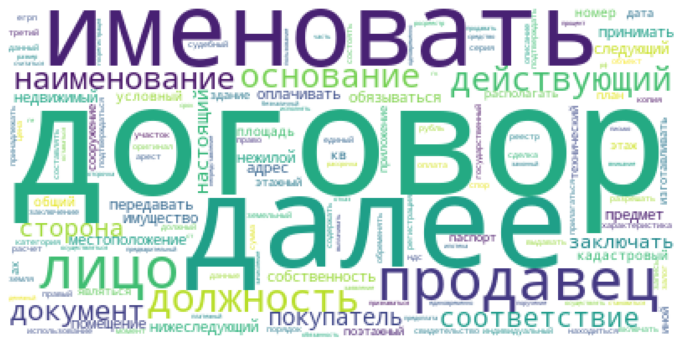

In [309]:
draw_word_cloud(data, 'Купля-продажа')

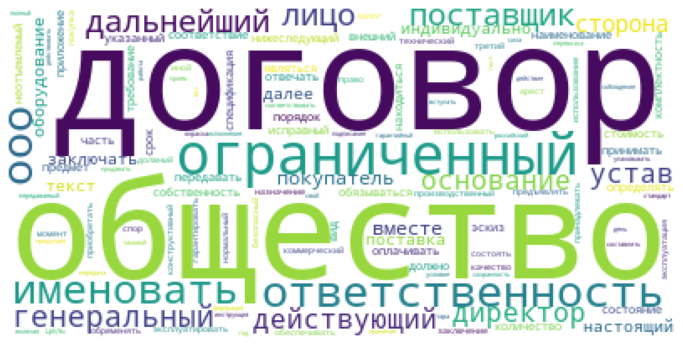

In [310]:
draw_word_cloud(data, 'Поставки')

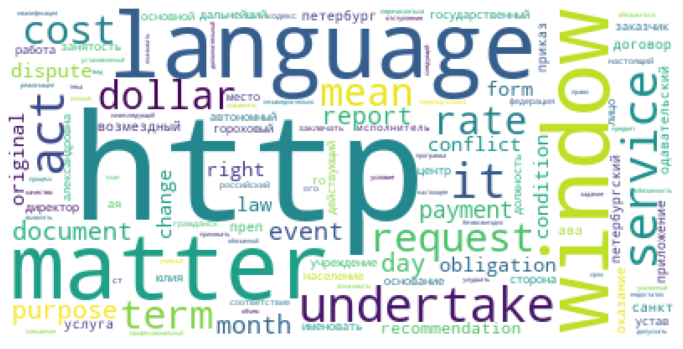

In [311]:
draw_word_cloud(data, 'Услуги')

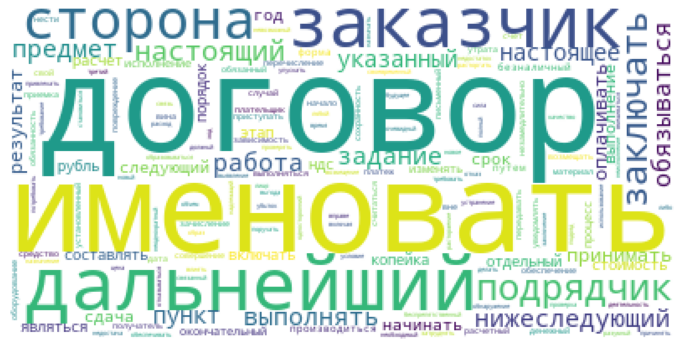

In [313]:
draw_word_cloud(data, 'Подряд')

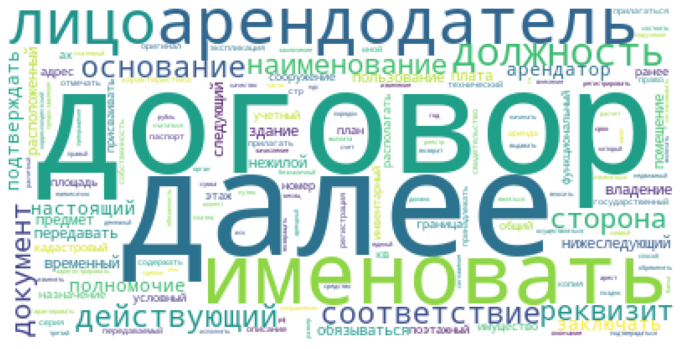

In [314]:
draw_word_cloud(data, 'Аренда')

## Расширение словаря стоп-слов
Расширим словарь стоп-слов, добавив туда наиболее частотные слова, встречающиеся во всех типах доков и не влиящих на тематику документа.


In [315]:
text = ''
for i in data['lemma_text'].values:
    text += i+' '

all_words = nltk.tokenize.word_tokenize(text.lower())
all_words_no_stop = nltk.FreqDist(w.lower() for w in all_words if w not in russian_stopwords)

In [ ]:
all_words_no_stop